# Bell State 

To illustrate a multi qubit application of quantum gates, we will create a Bell state. A Bell state is a two qubit state that is maximally entangled.

In [1]:
import sys
sys.path.append('..')

In [2]:
import cirq
import numpy as np
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.visualization import plot_histogram
import plotly.express as px
from sklearn.pipeline import Pipeline, make_pipeline

from skq.gates import HGate, CXGate, IdentityGate
from skq.qubit_transformers import SingleQubitTransformer, MultiQubitTransformer
from skq.measurement import MeasurementTransformer
from skq.pipeline import make_quantum_union

In [3]:
step1 = make_quantum_union(SingleQubitTransformer(HGate()), SingleQubitTransformer(IdentityGate()))
step2 = MultiQubitTransformer(CXGate())
step3 = MeasurementTransformer(repeat=1000)

pipe = make_pipeline(step1, step2, step3)

The quantum union will combine the Hadamard and the Identity matrix through a Kronecker product.

In [4]:
pipe

Pipeline(steps=[('quantumfeatureunion',
                 QuantumFeatureUnion(transformer_list=[('singlequbittransformer-1',
                                                        SingleQubitTransformer(gate=HGate([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]]))),
                                                       ('singlequbittransformer-2',
                                                        SingleQubitTransformer(gate=IdentityGate([[1.+0.j, 0.+0.j],
              [0.+0.j, 1.+0.j]])))])),
                ('multiqubittransformer',
                 MultiQubitTransformer(gate=CXGate([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]]))),
                ('measurementtransformer',
                 MeasurementTransformer(repeat=1000))])

In [5]:
# Transform |00> qubits
X = np.array([[1, 0, 0, 0]], dtype=complex)

The 2 steps will create the bell state.

$$\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$$

The 3rd step will measure the qubits to verify the state. This will results in 00 or 11 with equal probability.

In [6]:
# Bell state as a vector
pipe[:-1].transform(X)

array([[0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j]])

In [7]:
measurements = pipe.transform(X)

In [8]:
print(measurements.shape)
measurements[:5]

(1000, 2)


array([[0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1]])

In [9]:
# Convert measurements to a string representation for plotting
measurement_strings = [''.join(map(str, m)) for m in measurements]

# Plot the results using Plotly
fig = px.histogram(measurement_strings, x=measurement_strings, title="Measurement Results of Bell State",
                   labels={'x': 'Measurement Outcome', 'y': 'Count'}, text_auto=True)
fig.show()

# Qiskit

Each pipeline can be converted to a Qiskit circuit.

In [10]:
def pipeline_to_qiskit_circuit(pipeline: Pipeline, num_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)
    for _, step in pipeline.steps:
        if hasattr(step, 'transformer_list'):
            for n_qubit, (_, transformer) in enumerate(step.transformer_list):
                name = transformer.gate.__class__.__name__
                if name == 'IdentityGate':
                    continue
                qiskit_gate = transformer.gate.to_qiskit_gate(name)
                circuit.append(qiskit_gate, [n_qubit])
        elif hasattr(step, 'gate'):
            name = step.gate.__class__.__name__
            qiskit_gate = step.gate.to_qiskit_gate(name)
            circuit.append(qiskit_gate, range(step.gate.shape[0] // 2))
    return circuit

In [11]:
qiskit_circuit = pipeline_to_qiskit_circuit(pipe, 2)

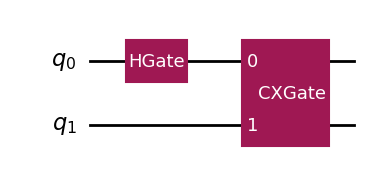

In [12]:
qiskit_circuit.draw('mpl')

In [13]:
# Add measurements to the circuit
qiskit_circuit.measure_all()

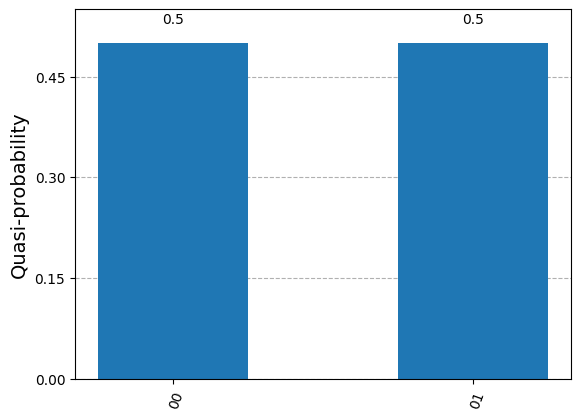

In [14]:
# Run the circuit using the Qiskit Sample
results = Sampler().run(qiskit_circuit).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

# Cirq

Also, our circuit can be conveniently converted to a Cirq circuit.

In [15]:
def pipeline_to_cirq_circuit(pipeline: Pipeline, num_qubits: int) -> cirq.Circuit:
    qubits = cirq.LineQubit.range(num_qubits)
    circuit = cirq.Circuit()
    
    for _, step in pipeline.steps:
        if hasattr(step, 'transformer_list'):
            for n_qubit, (_, transformer) in enumerate(step.transformer_list):
                gate = transformer.gate
                name = gate.__class__.__name__
                if name != 'IdentityGate':
                    circuit.append(gate.to_cirq_gate(qubits[n_qubit], name=name))
        elif hasattr(step, 'gate'):
            gate = step.gate
            name = gate.__class__.__name__
            qubit_indices = range(step.gate.shape[0] // 2)
            circuit.append(gate.to_cirq_gate(*[qubits[i] for i in qubit_indices], name=name))
    return circuit

In [16]:
cirq_circuit = pipeline_to_cirq_circuit(pipe, 2)

In [17]:
cirq_circuit.append(cirq.measure(*cirq_circuit.all_qubits(), key='result'))

In [18]:
cirq_circuit

┌                           ┐
      ┌                     ┐          │1.+0.j 0.+0.j 0.+0.j 0.+0.j│
0: ───│ 0.707+0.j  0.707+0.j│──────────│0.+0.j 1.+0.j 0.+0.j 0.+0.j│───────────M('result')───
      │ 0.707+0.j -0.707+0.j│          │0.+0.j 0.+0.j 0.+0.j 1.+0.j│           │
      └                     ┘[HGate]   │0.+0.j 0.+0.j 1.+0.j 0.+0.j│           │
                                       └                           ┘[CXGate]   │
                                       │                                       │
1: ────────────────────────────────────#2──────────────────────────────────────M─────────────

In [19]:
simulator = cirq.Simulator()
result = simulator.run(cirq_circuit, repetitions=10)

# Convert result to numpy array
result = np.array([list(v) for _, v in result.measurements.items()])
result

array([[[1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=int8)